Importing Libraries

In [1]:
from tqdm import tqdm 
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

from PIL import Image
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
from scipy.spatial import KDTree
from itertools import combinations
import open3d as o3d

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import numpy as np
from collections import deque
from tqdm import tqdm


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


File Paths

In [2]:
org_path="/mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/"
# org_path="G:/Projects/Depth_Reconstruction/Test_Folder/stereo_test/"

object_name="dustbin"

test_input_path=org_path+"test_images/"+object_name+"/"
test_output_path=org_path+"test_outputs/"
test_3d_path=org_path+"test_3d/"

left_path = test_input_path+"im0.png"
right_path = test_input_path+"im1.png"
# test_path= "/mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_images/dustbin/im0.png"

Accessory Functions

In [3]:

def load_image_to_rgb(image_path):
    """Load an image from path and return as RGB numpy array."""
    img = Image.open(image_path)
    return np.array(img.convert('RGB'))

In [4]:

def display_image_array(img_array):
    """Display a numpy image array (2D or 3D) without axes."""
    plt.figure()
    if len(img_array.shape) == 3:  # RGB image
        plt.imshow(img_array)
    else:  # Grayscale
        plt.imshow(img_array, cmap='gray')
    plt.axis('off')
    plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def display_2x2_grid(images, figsize=(10, 10)):
    
    if len(images) != 4:
        raise ValueError("Exactly 4 images required")
    
    # Create figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.ravel()  # Flatten to 1D array for easy indexing
    
    # Display each image with appropriate colormap
    for i, (img, ax) in enumerate(zip(images, axes)):
        if len(img.shape) == 3:  # RGB image
            ax.imshow(img)
        elif len(img.shape) == 2:  # Grayscale image
            ax.imshow(img, cmap='gray')
        else:
            raise ValueError(f"Image {i+1} has invalid shape {img.shape}")
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [6]:


def resize_image_array(image_array, scale_factor):
    # Convert array to PIL Image
    if len(image_array.shape) == 2:
        # Grayscale image
        img = Image.fromarray(image_array)
    elif len(image_array.shape) == 3:
        # RGB/RGBA image
        img = Image.fromarray(image_array.astype('uint8'))
    else:
        raise ValueError("Input array must be 2D (grayscale) or 3D (color)")
    
    # Calculate new dimensions
    width, height = img.size
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    
    # Resize using Lanczos resampling (high quality)
    resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Convert back to numpy array
    resized_array = np.array(resized_img)
    
    # Preserve original dtype for grayscale
    if len(image_array.shape) == 2:
        resized_array = resized_array.astype(image_array.dtype)
    
    return resized_array

In [7]:
def plot_disp_array(data_array):
    plt.figure(figsize=(8, 6))
    img = plt.imshow(data_array, cmap='viridis')
    plt.axis('off')
    cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
    cbar.set_label('Value Scale', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

In [8]:
def plot_viridis_matrix(matrix):
    # Visualize results
    plt.figure(figsize=(12, 5))
    plt.imshow(matrix, cmap='viridis')
    plt.title('Matrix')
    plt.colorbar()

In [9]:
def rgb_to_luminance(img_array):
    """Convert RGB image array to luminance (grayscale) using standard weights."""
    if len(img_array.shape) == 2:
        return img_array  # Already grayscale
    gray = np.dot(img_array[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)
    return gray.astype(np.int_)

Plotting Functions

In [10]:

def plot_colorized_segments(array_2d):
    
    # Calculate value occurrences (excluding zeros from frequency calculation)
    flat_array = array_2d.flatten()
    value_counts = Counter(flat_array)
    unique_values = np.array(sorted(value_counts.keys()))
    
    # Separate zero and non-zero values
    zero_exists = 0 in value_counts
    non_zero_values = unique_values[unique_values != 0] if zero_exists else unique_values
    
    # Create Viridis colormap for non-zero values
    if len(non_zero_values) > 0:
        non_zero_counts = np.array([value_counts[v] for v in non_zero_values])
        norm_counts = (non_zero_counts - non_zero_counts.min()) / \
                    (non_zero_counts.max() - non_zero_counts.min() + 1e-10)
        cmap = plt.cm.viridis # type: ignore
        
        # Assign colors (using 0.1-0.9 range of Viridis to avoid extremes)
        color_dict = {val: cmap(0.1 + 0.8*norm_counts[i]) 
                     for i, val in enumerate(non_zero_values)}
    
    # Always set 0 to black
    if zero_exists:
        color_dict[0] = (0, 0, 0, 1)  # Black with full opacity
    
    # Create RGB image
    rgb_image = np.zeros((*array_2d.shape, 3))
    for val in color_dict:
        rgb_image[array_2d == val] = color_dict[val][:3]  # Exclude alpha channel
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # return color_dict  # Optional: return the color mapping

In [11]:

def plot_value_occurrences(array_2d):
    """
    Plot the occurrence of values in a 2D array as a histogram.
    
    Args:
        array_2d: 2D numpy array with non-negative integer values
    """
    # Flatten array and count occurrences
    flat_array = array_2d.flatten()
    value_counts = Counter(flat_array)
    
    # Extract values and counts
    values = np.array(sorted(value_counts.keys()))
    counts = np.array([value_counts[v] for v in values])
    
    if values[0]==0:
        values=values[1:]
        counts=counts[1:]
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot histogram
    bars = plt.bar(values, counts, color='skyblue', edgecolor='black')
    
    # Customize plot
    plt.xlabel('Value')
    plt.ylabel('Occurrences')
    plt.title('Value Occurrences in 2D Array')
    plt.grid(axis='y', alpha=0.5)
    
    # If there are many values, rotate x-axis labels
    if len(values) > 20:
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

Texture Segmentation

In [12]:

def texture_segmentation(image, threshold, scale_stop, max_texture):
    """
    Segment image into textures using randomized flood fill until all pixels are processed.
    Shows progress with tqdm bar and displays current texture value.
    """
    h, w = image.shape
    output = np.zeros_like(image)
    texture = 1
    
    stop_value = int(h*w *scale_stop)
    
    max_t = int(np.sqrt(h*w*max_texture))
    
    # Initialize progress bar
    total_pixels = h * w
    
    with tqdm(total=total_pixels, desc="Segmenting textures") as pbar:
        # Update progress with initially filled pixels (probably 0)
        pbar.update(np.count_nonzero(output))
        
        while True:
            # Find all unprocessed pixels (value = 0)
            zero_pixels = np.argwhere(output == 0)
            if len(zero_pixels) < stop_value:
                break  # Exit when complete
            
            # Randomly select a starting pixel
            
            y, x = random.choice(zero_pixels)
            
            current_value = image[y, x]
            stack = [(y, x)]
            
            # Perform flood fill
            
            texture_count=0
            
            org_y, org_x = y, x
            
            while stack:
                y, x = stack.pop()
                if output[y, x] != 0:
                    continue
                    
                output[y, x] = texture
                texture_count+=1
                
                if max(abs(y-org_y),abs(x-org_x))>max_t:
                    continue
                
                # Check 4-connected neighbors
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if (0 <= ny < h and 0 <= nx < w and output[ny, nx]!=texture and abs(int(image[ny, nx]) - int(current_value)) <= threshold):
                        
                        stack.append((ny, nx))
            
            # Update progress bar
            pbar.update(texture_count)
            pbar.set_postfix({'Current texture': texture})
            
            texture += 1
    
    return output

Generating Disparity over constant Textures

In [13]:

def compute_texture_data(image_array, texture_array):
    # Initialize arrays
    height, width = texture_array.shape
    searched = np.zeros_like(texture_array, dtype=bool)
    
    texture_dict={}
    
    # Define 4-connected neighborhood
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    # Main processing loop with progress bar
    for y in tqdm(range(height), desc="Mean Texture Generator"):
        for x in range(width):
            if searched[y, x]:
                continue
                
            current_texture = texture_array[y, x]
            if current_texture == 0:  # Skip background (if needed)
                searched[y, x] = True
                continue
            
            if current_texture in texture_dict:
                searched[y, x] = True
                continue
            
            # BFS to find all connected pixels with same texture
            queue = deque([(y, x)])
            region = []
            
            while queue:
                cy, cx = queue.popleft()
                
                if searched[cy, cx]:
                    continue
                    
                searched[cy, cx] = True
                region.append((cy, cx))
                
                # Check neighbors
                for dy, dx in directions:
                    ny, nx = cy + dy, cx + dx
                    if (0 <= ny < height and 0 <= nx < width and 
                        not searched[ny, nx] and 
                        texture_array[ny, nx] == current_texture):
                        queue.append((ny, nx))
            
            # Calculate SAD for this region (example implementation)
            # Here we just use the mean intensity as a placeholder
            # Replace this with your actual SAD calculation
            region_sad = np.mean([image_array[py, px] for py, px in region])
            
            region_mean_pixel = [int(round(np.mean([y for y,_ in region]))),int(round(np.mean([x for _,x in region])))]
            # Assign SAD value to all pixels in the region
            
            texture_dict[current_texture] = (region_sad, region_mean_pixel)
                
    return texture_dict

In [14]:
def find_sad_texture(image_array, texture_array, texture_dict, origin, org_value, search_range):
    
    height, width = texture_array.shape
    y, x = origin
    
    # Generate search points (leftwards from origin)
    search_list = [(y, x - d) for d in range(search_range + 1) ]
    
    min_diff = float('inf')
    result_tuple = (0, [])
    
    for point in search_list:
        cy, cx = point
        
        # Boundary check
        if not (0 <= cy < height and 0 <= cx < width):
            continue
            
        texture_val = texture_array[cy, cx]
        
        # Skip if texture is 0 or not in dictionary
        if texture_val == 0:
            stored_value, point = image_array[cy, cx], (cy, cx)
        
        else:
            stored_value, point = texture_dict[texture_val]
        
        current_diff = abs(org_value - stored_value)
        
        if current_diff < min_diff:
            min_diff = current_diff
            result_tuple = (stored_value, point)
    
    return result_tuple

In [15]:

def generate_disparity(image_l, image_r, text_l, text_r, search):
    
    # Precompute texture data
    dict_l = compute_texture_data(image_l, text_l)
    dict_r = compute_texture_data(image_r, text_r)
    
    # Cache for storing already matched textures
    texture_match_cache = {}
    
    disparity = np.zeros_like(image_l)
    
    for y in tqdm(range(len(disparity)), desc="Disparity Generator"):
        for x in range(len(disparity[y])):
            org_texture = text_l[y, x]
            
            if org_texture == 0:  # Skip background
                org_value, origin = image_l[y, x], (y,x)
                
            else:
                org_value, origin = dict_l[org_texture]
                
            # Check cache first
            if org_texture in texture_match_cache:
                dest_point = texture_match_cache[org_texture]
                
            else:
                # Compute if not in cache
                _, dest_point = find_sad_texture(image_r,text_r, dict_r, origin, org_value, search)
                
                if org_texture!=0:
                    texture_match_cache[org_texture] = dest_point
                
            val = origin[1] - dest_point[1]
            disparity[y, x] = val if val>0 else 0
            # disparity[y, x] = np.sqrt((origin[1] -dest_point[1])**2 + (origin[0]-dest_point[0])**2)
            
    return disparity

Post Processing

In [16]:
def post_process(disp_matrix,avg_len,mode_len,max_avg,max_mode,max_disp):
    pp_disp = np.copy(disp_matrix)
    H, W = pp_disp.shape

    for y in range(H):
        for x in range(W):

            # 1. SMOOTHING by average
            if y >= avg_len and y < H - avg_len and x >= avg_len and x < W - avg_len:
                avg = np.mean(pp_disp[y - avg_len:y + avg_len+1, x - avg_len:x + avg_len+1])
                if abs(pp_disp[y, x] - avg) > max_avg:
                    pp_disp[y, x] = avg

            # 2. DENOISING by mode
            if pp_disp[y, x] > max_mode:
                if y >= mode_len and y < H - mode_len and x >= mode_len and x < W - mode_len:
                    window = pp_disp[y - mode_len:y + mode_len+1, x - mode_len:x + mode_len+1].flatten()
                    mode_val = stats.mode(window, keepdims=False).mode
                    if mode_val.size > 0:
                        pp_disp[y, x] = mode_val.item()

            # 3. HARD THRESHOLD
            if pp_disp[y, x] > max_disp:
                pp_disp[y, x] = max_mode

    return pp_disp

In [17]:
def denoise_disparity(disp_matrix,avg_len,mode_len,max_avg,max_mode,max_disp,iterations):
    
    for _ in tqdm(range(iterations), desc="Denoising Disparity"):
        disp_matrix=post_process(disp_matrix,avg_len,mode_len,max_avg,max_mode,max_disp)
    
    return disp_matrix

Creating 3D model

In [18]:
def create_txt(image_array, disp_matrix,resize_scale, output_path):
    
    baseline = 178.232
    focus = 2945.377
    doffs = 170.681

    height = image_array.shape[0]
    width = image_array.shape[1]

    xyzrgb = []

    for x in tqdm(range(width),desc="Point Cloud Creation"):
        for y in range(height):
            disp = disp_matrix[y, x]
            
            # if disp==0:
            #     continue
            z = (baseline*focus)/(disp*(1/resize_scale)+doffs)
            z=z*resize_scale
            
            # z=-500
            
            rgb = image_array[y, x]
            xyzrgb.append([x, y, z, rgb[0], rgb[1], rgb[2]])

    df = pd.DataFrame(xyzrgb)
    df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
    df.to_csv(output_path, index=False)

    print(f"Successfully created file at {output_path}.")

    return df

In [19]:

def pointcloud_to_ply(input_path, output_path, threshold=0.1):
    """
    Converts a structured point cloud text file to a binary_little_endian .ply mesh file using Open3D.
    Faces are only created when all pairwise distances between triangle vertices are < threshold.
    Only one threshold parameter is now used; euclid_threshold is ignored.
    """
    # Load data
    data = np.loadtxt(input_path, delimiter=',', skiprows=1) # type: ignore
    raw_coords = data[:, :3].astype(np.float64)
    raw_colors = data[:, 3:].astype(np.uint8)

    # Flip Z-axis if needed
    # raw_coords[:, 2] *= -1

    # Deduplicate vertices
    vertex_map = {}
    vertices = []
    color_list = []
    index_lookup = []

    for i in range(len(raw_coords)):
        key = tuple(np.round(raw_coords[i], 5))
        if key not in vertex_map:
            vertex_map[key] = len(vertices)
            vertices.append(raw_coords[i])
            color_list.append(raw_colors[i])
        index_lookup.append(vertex_map[key])

    vertices = np.array(vertices, dtype=np.float64)
    color_list = np.array(color_list, dtype=np.uint8)
    index_lookup = np.array(index_lookup)

    # Infer 2D grid shape
    try:
        diffs = np.diff(raw_coords[:, 1])
        W = np.where(diffs < 0)[0][0] + 1
    except IndexError:
        raise ValueError("Couldn't infer width from data.")

    H = len(raw_coords) // W
    if H * W != len(raw_coords):
        raise ValueError("Point count does not match inferred grid dimensions.")

    index_map = index_lookup.reshape(H, W)

    # Helper to check pairwise distances
    def all_pairwise_within_threshold(p1, p2, p3, max_dist):
        return (
            np.linalg.norm(p1 - p2) < max_dist and
            np.linalg.norm(p2 - p3) < max_dist and
            np.linalg.norm(p3 - p1) < max_dist
        )

    # Grid-based triangle generation
    face_set = set()
    faces = []

    for y in range(H - 1):
        for x in range(W - 1):
            i1, i2, i3 = index_map[y, x], index_map[y, x + 1], index_map[y + 1, x]
            i4 = index_map[y + 1, x + 1]

            # Triangle 1
            if -1 not in [i1, i2, i3]:
                p1, p2, p3 = vertices[i1], vertices[i2], vertices[i3]
                if all_pairwise_within_threshold(p1, p2, p3, threshold):
                    face = tuple(sorted([i1, i2, i3]))
                    if face not in face_set:
                        face_set.add(face)
                        faces.append(list(face))

            # Triangle 2
            if -1 not in [i2, i4, i3]:
                p1, p2, p3 = vertices[i2], vertices[i4], vertices[i3]
                if all_pairwise_within_threshold(p1, p2, p3, threshold):
                    face = tuple(sorted([i2, i4, i3]))
                    if face not in face_set:
                        face_set.add(face)
                        faces.append(list(face))

    # KDTree-based triangle generation (optional, using same threshold)
    
    # tree = KDTree(vertices)
    # for i in tqdm(range(len(vertices)), desc="KDTree neighbors"):
    #     neighbors = tree.query_ball_point(vertices[i], threshold)
    #     for j in neighbors:
    #         if j > i:
    #             k = (i + 1) % len(vertices)
    #             if k != i and k != j:
    #                 p1, p2, p3 = vertices[i], vertices[j], vertices[k]
    #                 if all_pairwise_within_threshold(p1, p2, p3, threshold):
    #                     face = tuple(sorted([i, j, k]))
    #                     if face not in face_set:
    #                         face_set.add(face)
    #                         faces.append(list(face))

    # Construct mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    mesh.vertex_colors = o3d.utility.Vector3dVector(color_list.astype(np.float64) / 255.0)

    # Save mesh as binary little endian
    o3d.io.write_triangle_mesh(output_path, mesh, write_ascii=False, compressed=False)
    print(f"Successfully saved mesh at: {output_path}")


In [20]:
def render_object(image_array,disparity,resize_scale,ply_threshold):
    
    height, width, cl = image_array.shape
    
    output_image_path = test_output_path+f"{object_name}_{height}.png"
    output_txt_path = test_3d_path+f"{object_name}_point_cloud_{height}.txt"
    output_3d_path = test_3d_path+f"{object_name}_ply_{height}.ply"
    
    df = create_txt(image_array,disparity,resize_scale,output_txt_path)
    
    pointcloud_to_ply(output_txt_path,output_3d_path,ply_threshold)
    
    # plt.imshow(disparity)
    plt.savefig(output_image_path)

Execution

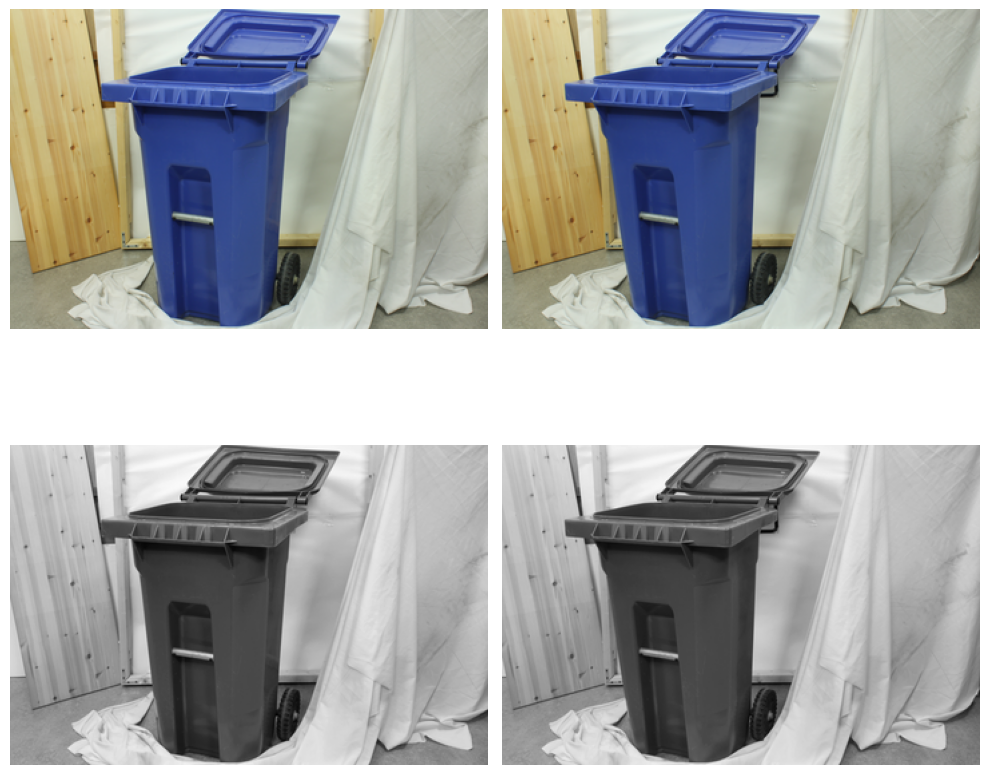

In [21]:
image_array_l = load_image_to_rgb(left_path)
image_array_r = load_image_to_rgb(right_path)

resize_scale = 0.125

rgb_l = resize_image_array(image_array_l,resize_scale)
rgb_r = resize_image_array(image_array_r,resize_scale)

gray_array_l = rgb_to_luminance(rgb_l)
gray_array_r = rgb_to_luminance(rgb_r)

display_2x2_grid([rgb_l,rgb_r,gray_array_l,gray_array_r])



In [22]:
thresh=0.03
stop_comp =0.05

max_text = 0.0001

print("Image Shape - ",gray_array_l.shape)
print("Total Pixels - ",(gray_array_l.shape[0]*gray_array_l.shape[1]))

th_val = thresh*255

texture_l = texture_segmentation(gray_array_l,threshold=th_val,scale_stop=stop_comp,max_texture=max_text/4)
texture_r = texture_segmentation(gray_array_r,threshold=th_val,scale_stop=stop_comp,max_texture=max_text/4)

Image Shape -  (240, 358)
Total Pixels -  85920


Segmenting textures:  95%|█████████▌| 81626/85920 [00:06<00:00, 13003.81it/s, Current texture=10719]


8.592


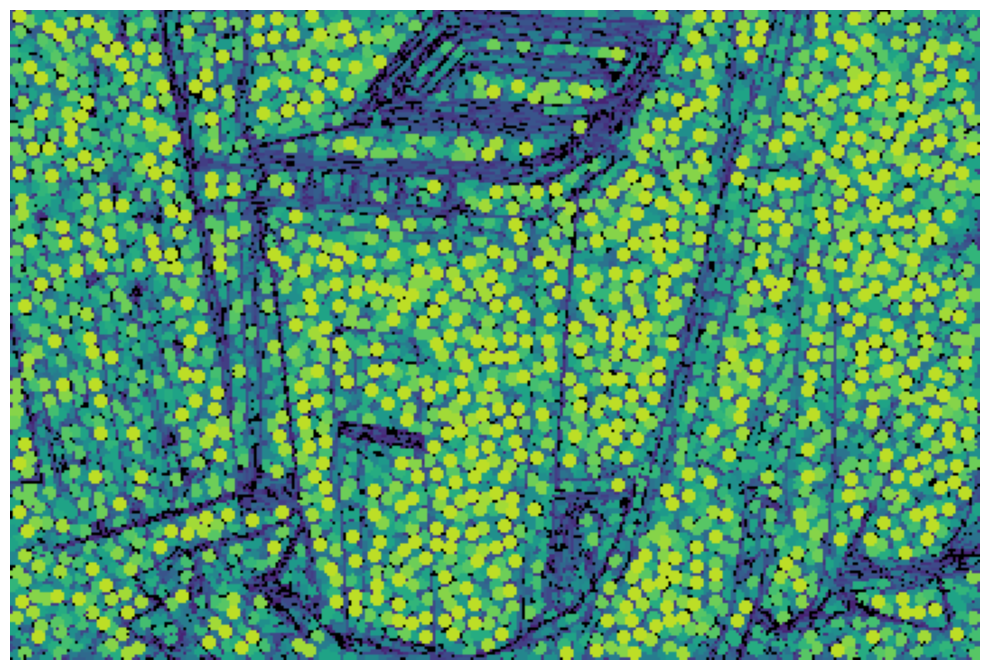

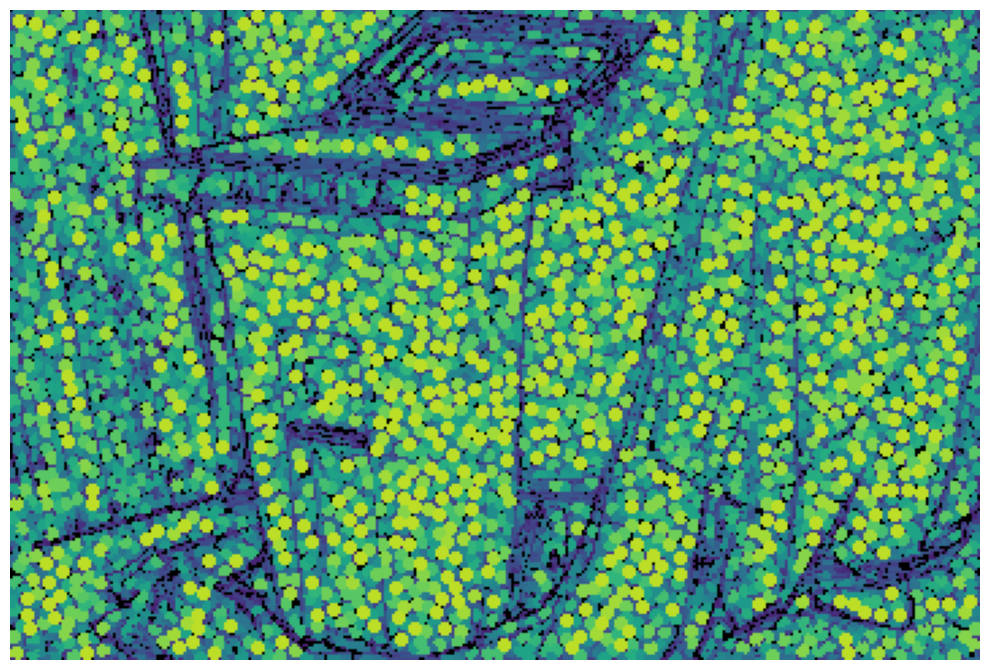

In [23]:
max_plot = (gray_array_l.shape[0]*gray_array_l.shape[1]) * max_text
print(max_plot)

plot_colorized_segments(texture_l)
plot_colorized_segments(texture_r)

In [24]:
# plot_value_occurrences(texture_l)
# plot_value_occurrences(texture_r)

In [25]:
search_scale = 0.05 

search = int(search_scale * gray_array_l.shape[1])

disp_matrix = generate_disparity(gray_array_l,gray_array_r,texture_l,texture_r,search)

disp_max = np.max(disp_matrix)
disp_avg = np.mean(disp_matrix)

avg_len = int(0.04 * gray_array_l.shape[1])
mode_len = int(0.1 * gray_array_l.shape[1])

max_avg = disp_avg
max_mode = disp_avg

max_disp = disp_max 

iterations = 20

disp_matrix = denoise_disparity(disp_matrix,avg_len,mode_len,max_avg,max_mode,max_disp,iterations)

print("Search Distance - ",search)

# print(disp_matrix)
# print(np.max(disp_matrix))
# print(np.min(disp_matrix))
# print(np.mean(disp_matrix))


Denoising Disparity: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]

Search Distance -  17


Point Cloud Creation: 100%|██████████| 358/358 [00:00<00:00, 2030.31it/s]


Successfully created file at /mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_3d/dustbin_point_cloud_240.txt.
Successfully saved mesh at: /mnt/Personal/Projects/Depth_Reconstruction/Test_Folder/stereo_test/test_3d/dustbin_ply_240.ply


<Figure size 640x480 with 0 Axes>

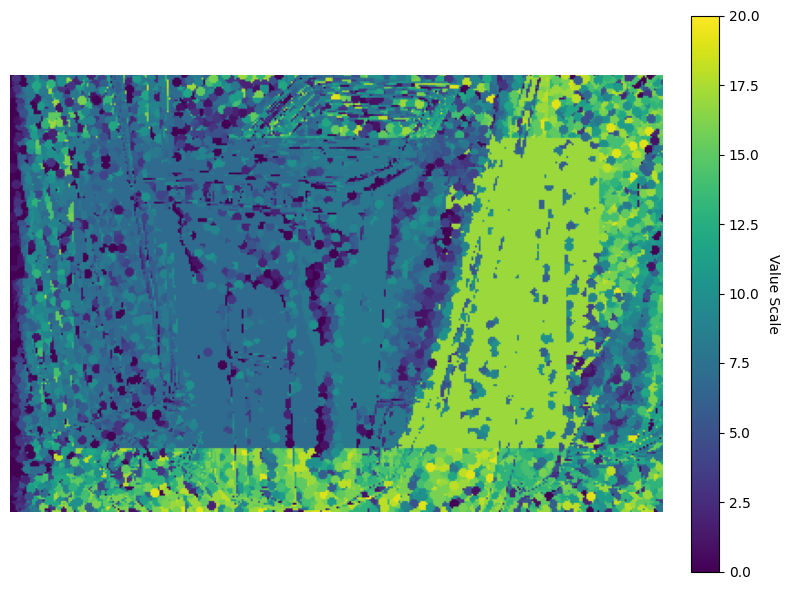

In [26]:
render_object(rgb_l,disp_matrix,resize_scale,10)

plot_disp_array(disp_matrix)

Peak Smoothing: 100%|██████████| 17184/17184 [00:00<00:00, 110400.26it/s]


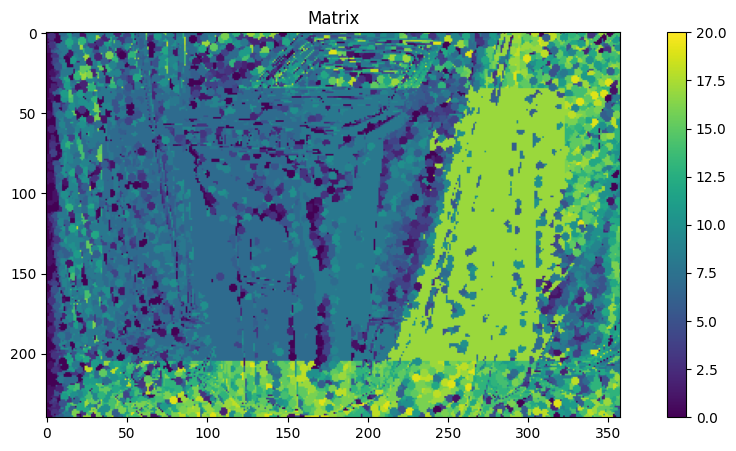

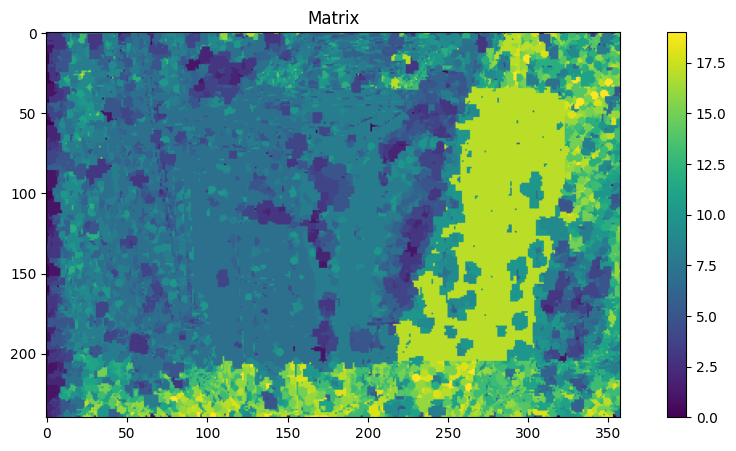

In [27]:
import numpy as np
import random

import numpy as np
import random
from tqdm import tqdm

def random_smoothing(matrix, patch_range=3, threshold=0.2, iterate=0.0, aggressive=False):
    """
    Smooth sharp peaks in a 2D array using localized averaging.
    
    Args:
        matrix: Input 2D numpy array
        patch_range: Radius of smoothing neighborhood (patch size = 2*patch_range+1)
        threshold: Maximum allowed deviation from median (0-1)
        iterations: Number of random patches to process
        aggressive: If True, replaces entire patch with median when peak is found
        
    Returns:
        Smoothed numpy array with reduced sharp peaks
    """
    
    smoothed = matrix.copy()
    height, width = smoothed.shape
    
    iterations = int(iterate * (height*width))
    
    for _ in tqdm(range(iterations), desc="Peak Smoothing"):
        # Generate random center point (avoiding edges)
        y = random.randint(patch_range, height - 1 - patch_range)
        x = random.randint(patch_range, width - 1 - patch_range)
        
        # Extract patch
        patch = smoothed[y-patch_range:y+patch_range+1, x-patch_range:x+patch_range+1]
        
        # Use median (more robust to outliers)
        patch_median = np.median(patch)
        
        # Skip if median is zero
        if patch_median == 0:
            continue
        
        if aggressive:
            # Replace entire patch if any sharp peak is found
            if np.any(np.abs(patch - patch_median)/patch_median > threshold):
                smoothed[y-patch_range:y+patch_range+1, x-patch_range:x+patch_range+1] = patch_median
        else:
            # Only modify values beyond threshold
            relative_diff = np.abs(patch - patch_median) / patch_median
            peak_mask = relative_diff > threshold
            patch[peak_mask] = patch_median
            smoothed[y-patch_range:y+patch_range+1, x-patch_range:x+patch_range+1] = patch
    
    return smoothed

smoothed = random_smoothing(disp_matrix,threshold=0.5,patch_range=2,iterate=0.2,aggressive=False)

plot_viridis_matrix(disp_matrix)
plot_viridis_matrix(smoothed)

In [28]:
# render_object(rgb_l,smoothed,resize_scale,10)